In [10]:
import pandas as pd
import numpy as np
import io
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, precision_recall_curve, classification_report
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv('C:/Users/Administrator/Desktop/DS Projects/DS Projects DataFiles/P6/Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


***
# **EDA**

## 1) Dataset Overview:

In [12]:
# Data Cleaning & Preprocessing
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df.dropna(inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)
else:
    print("'customerID' column was already dropped.")
#CustomerID column dropped because it's an 'identifier' and has no predictive value for the model.

In [13]:
# Total number of rows and columns in the dataset
print(f"Total rows and columns: {df.shape}")

# Data types of each column
df.info()

Total rows and columns: (7032, 20)
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMetho

In [14]:
# Categorical, Numerical, or Binary Columns
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include='object').columns
print("Numerical Columns:")
print(numerical_cols.tolist())
print("\nCategorical Columns:")
print(categorical_cols.tolist())
# from ML perspective Categorical and Binary are treated as one under object type regardless of the number of unique values.

# 5: How many unique values are there in each categorical variable?
print("\nUnique Values in Categorical Variables")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

Numerical Columns:
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Categorical Columns:
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

Unique Values in Categorical Variables
gender: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
Churn: 2 unique values


## 2) Data Quality Checks:

In [15]:
# 1: Missing values in any column
# 2: Blank spaces stored as empty strings
# Note: Already handled in the initial data cleaning.
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
print(df.isnull().sum())
print("\nResult: All missing values and blank spaces have been handled.")


# 3: Does TotalCharges contain non-numeric values?
print(f"Current data type of TotalCharges: {df['TotalCharges'].dtype}")
if pd.to_numeric(df['TotalCharges'], errors='coerce').isnull().sum() == 0:
    print("'TotalCharges' is now a fully numeric column.")
else:
    print("'TotalCharges' still contains non-numeric values.")


# 4: Are there duplicate customerID entries?
#'CustomerID' column has been dropped prior in data cleaning.


# 5: Is TotalCharges approximately equal to MonthlyCharges × tenure?
# Create a new column with the calculated total charges
df['CalculatedTotalCharges'] = df['MonthlyCharges'] * df['tenure']
# Find the difference between the actual and calculated values
df['Difference'] = abs(df['TotalCharges'] - df['CalculatedTotalCharges'])

print(f"Maximum difference between TotalCharges and (MonthlyCharges * tenure): {df['Difference'].max():.2f}")
print("On average, the difference is close to zero, indicating the relationship holds.")

# Clean up the new columns created for the check
df.drop(['CalculatedTotalCharges', 'Difference'], axis=1, inplace=True)

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Result: All missing values and blank spaces have been handled.
Current data type of TotalCharges: float64
'TotalCharges' is now a fully numeric column.
Maximum difference between TotalCharges and (MonthlyCharges * tenure): 373.25
On average, the difference is close to zero, indicating the relationship holds.


## 3) Target Variable Analysis:

In [16]:
# 1: Churn rate (%)?
churn_rate = (df['Churn'].value_counts(normalize=True) * 100).round(2)
print(f"\nChurn Rate:\n{churn_rate}")

# 2: Target variable (Churn) balanced or imbalanced?
if (churn_rate['No'] > 60) or (churn_rate['Yes'] > 60):
    print("The target variable 'Churn' is imbalanced.")
else:
    print("The target variable 'Churn' is balanced.")

# 3: Churn value frequency?
more_frequent_value = df['Churn'].value_counts().idxmax()
print(f"The more frequent churn value is: '{more_frequent_value}'")


Churn Rate:
Churn
No     73.42
Yes    26.58
Name: proportion, dtype: float64
The target variable 'Churn' is imbalanced.
The more frequent churn value is: 'No'


## 4) Univariate Analysis:

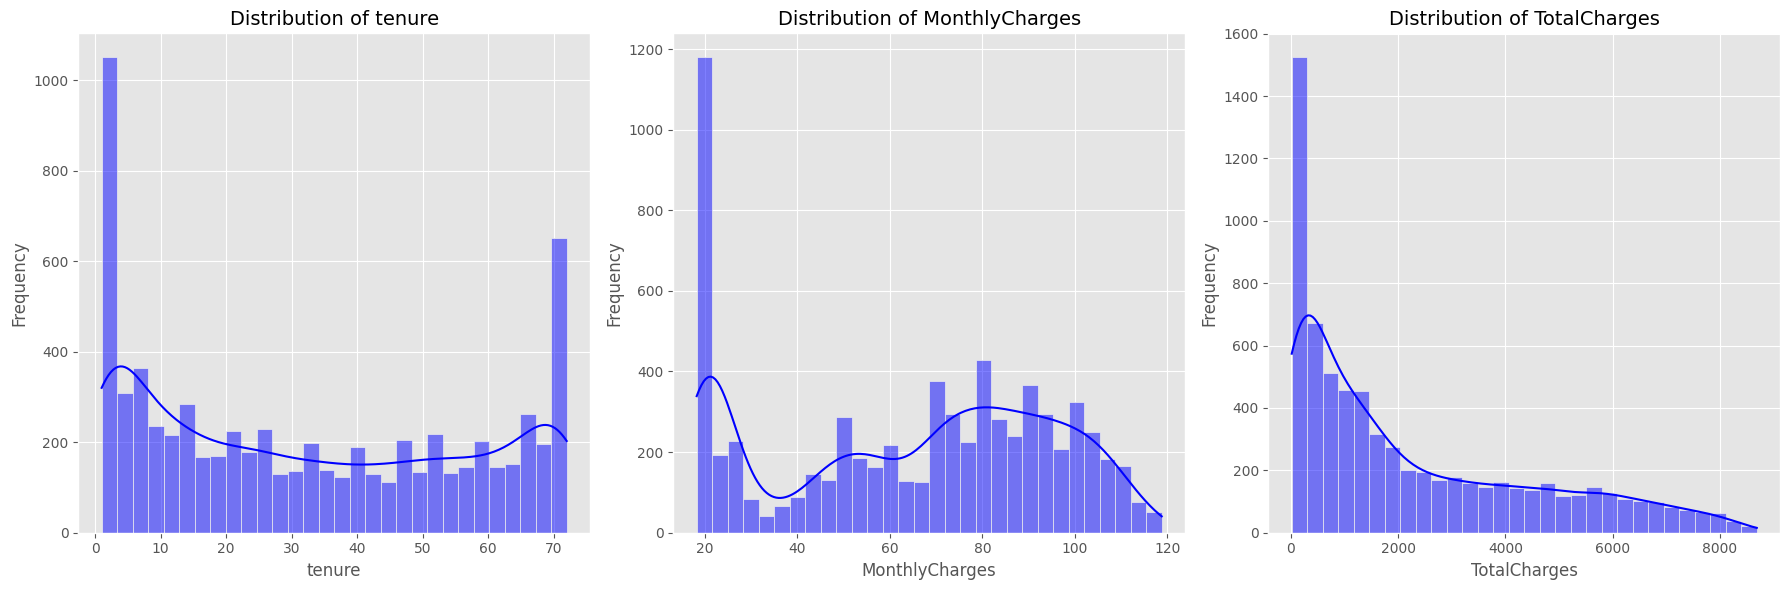

InternetService
Fiber optic    3096
DSL            2416
No             1520
Name: count, dtype: int64


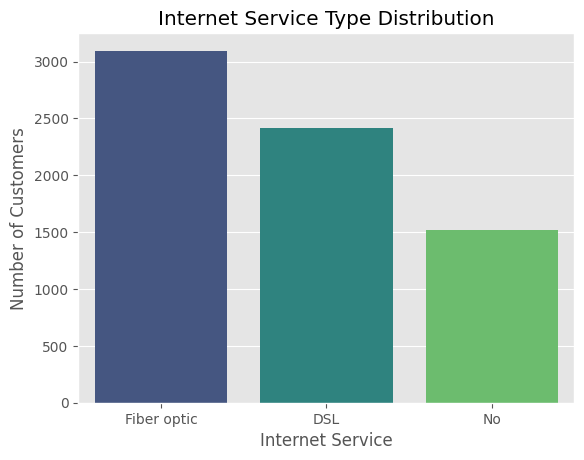

Contract
Month-to-month    3875
Two year          1685
One year          1472
Name: count, dtype: int64


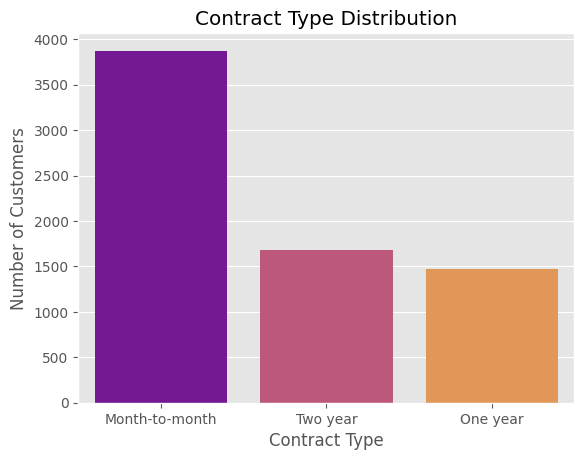

PaymentMethod
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: count, dtype: int64


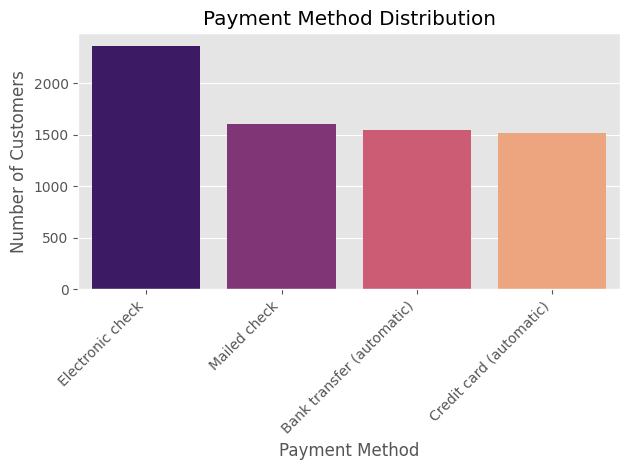

                   Yes    No  No internet service
Add-on                                           
OnlineSecurity    2015  3497                 1520
OnlineBackup      2425  3087                 1520
DeviceProtection  2418  3094                 1520
TechSupport       2040  3472                 1520
StreamingTV       2703  2809                 1520
StreamingMovies   2731  2781                 1520


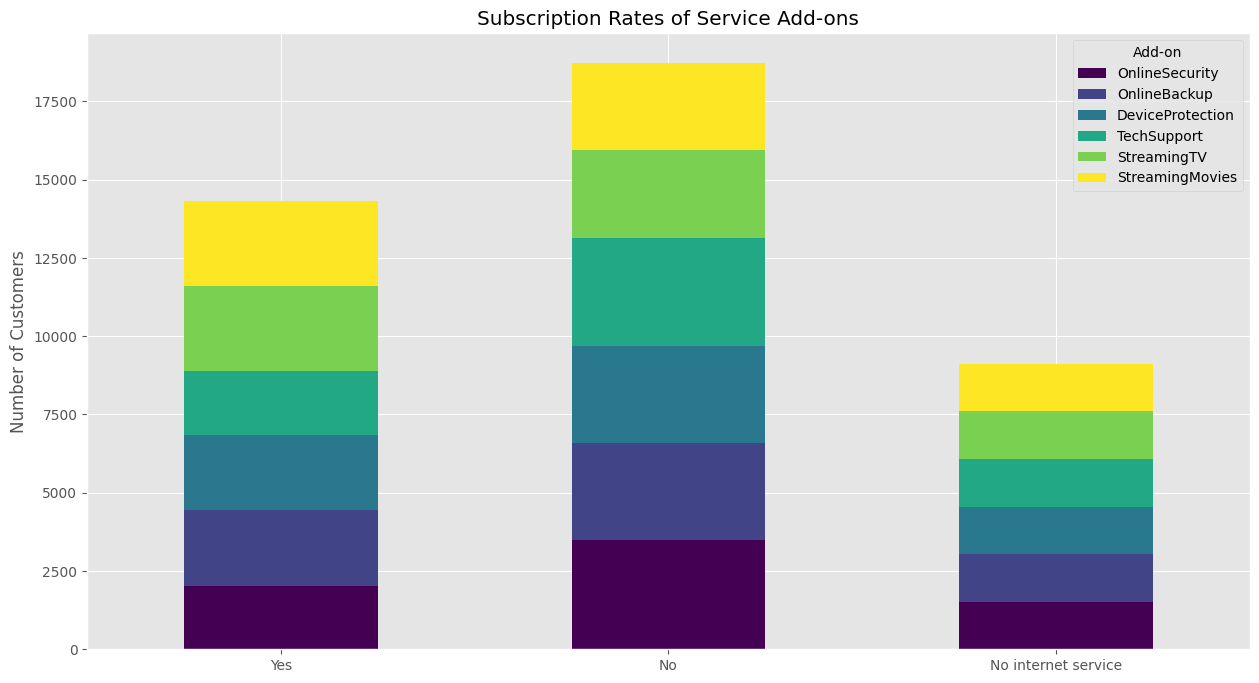

In [17]:
# 1: Distribution of tenure, MonthlyCharges, and TotalCharges?
numerical_cols_to_plot = ['tenure', 'MonthlyCharges', 'TotalCharges']

plt.style.use('ggplot')
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(numerical_cols_to_plot):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i], color='blue')
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


# 2: Most common internet service type?
internet_service_counts = df['InternetService'].value_counts()
print(internet_service_counts)
sns.barplot(x=internet_service_counts.index, y=internet_service_counts.values, hue= internet_service_counts.index,palette='viridis')
plt.title('Internet Service Type Distribution')
plt.ylabel('Number of Customers')
plt.xlabel('Internet Service')
plt.show()


# 3: Most Popular Contract Type
contract_counts = df['Contract'].value_counts()
print(contract_counts)
sns.barplot(x=contract_counts.index, y=contract_counts.values, hue=contract_counts.index, palette='plasma')
plt.title('Contract Type Distribution')
plt.ylabel('Number of Customers')
plt.xlabel('Contract Type')
plt.show()


# 4: Most used payment method
payment_method_counts = df['PaymentMethod'].value_counts()
print(payment_method_counts)
sns.barplot(x=payment_method_counts.index, y=payment_method_counts.values, hue=payment_method_counts.index, palette='magma')
plt.title('Payment Method Distribution')
plt.ylabel('Number of Customers')
plt.xlabel('Payment Method')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 5: Most/Least subscribed service add-ons?
add_on_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
add_on_counts = pd.DataFrame(columns=['Add-on', 'Yes', 'No', 'No internet service'])

for col in add_on_cols:
    counts = df[col].value_counts().reindex(['Yes', 'No', 'No internet service'], fill_value=0)
    add_on_counts.loc[len(add_on_counts)] = [col] + counts.tolist()

add_on_counts.set_index('Add-on', inplace=True)
print(add_on_counts)

add_on_counts.T.plot(kind='bar', figsize=(15, 8), stacked=True, colormap='viridis')
plt.title('Subscription Rates of Service Add-ons')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()

## 5) Bivariate Analysis:

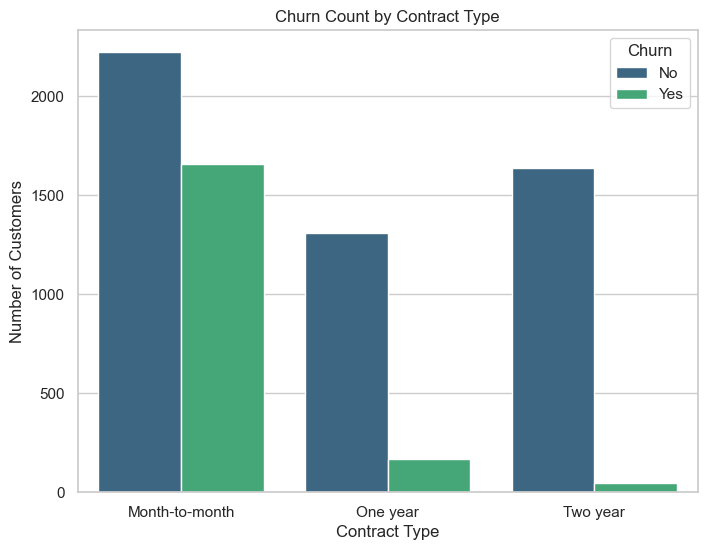

Churn             No   Yes
Contract                  
Month-to-month  0.57  0.43
One year        0.89  0.11
Two year        0.97  0.03


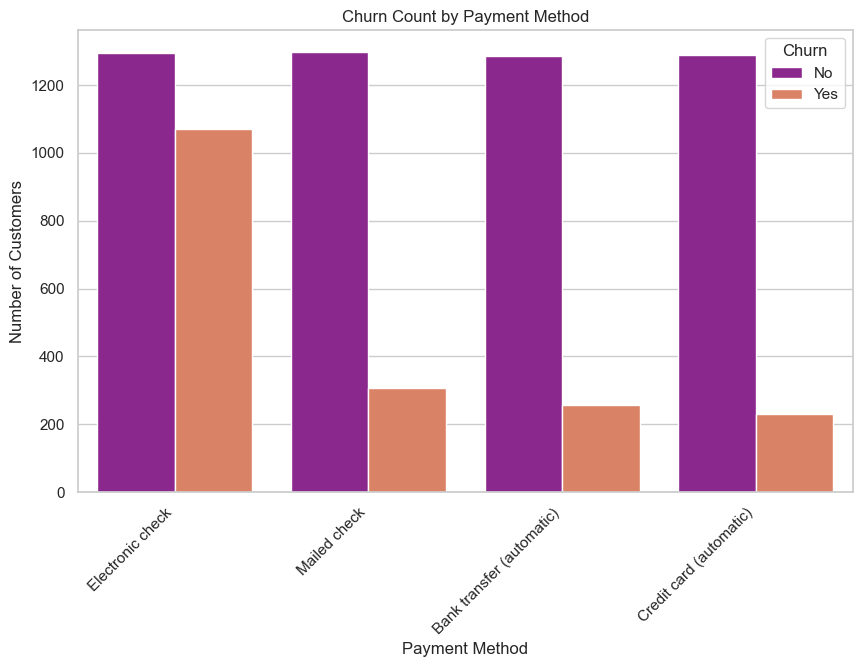

Churn                        No   Yes
PaymentMethod                        
Bank transfer (automatic)  0.83  0.17
Credit card (automatic)    0.85  0.15
Electronic check           0.55  0.45
Mailed check               0.81  0.19


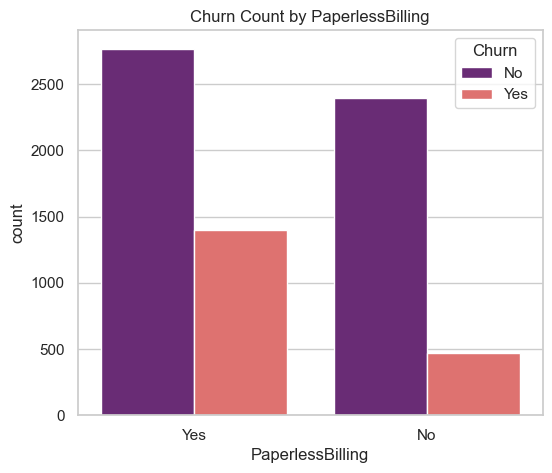

Churn               No   Yes
PaperlessBilling            
No                0.84  0.16
Yes               0.66  0.34


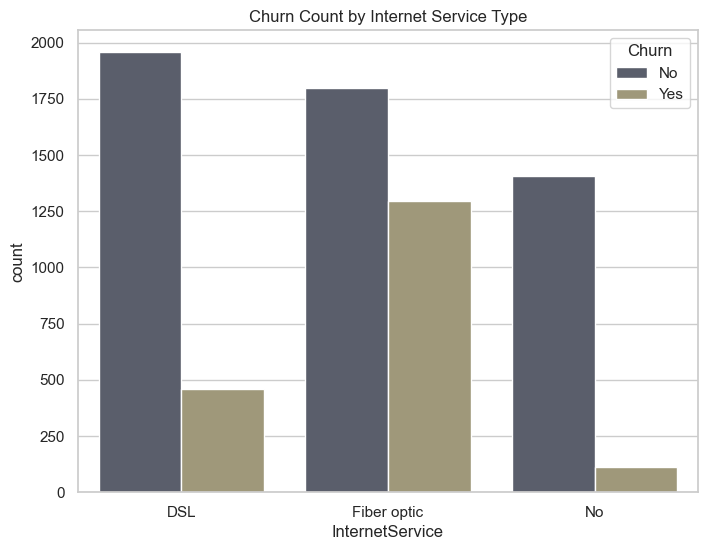

Churn              No   Yes
InternetService            
DSL              0.81  0.19
Fiber optic      0.58  0.42
No               0.93  0.07


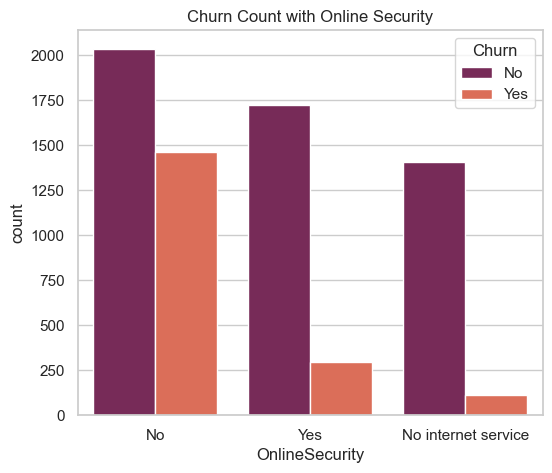

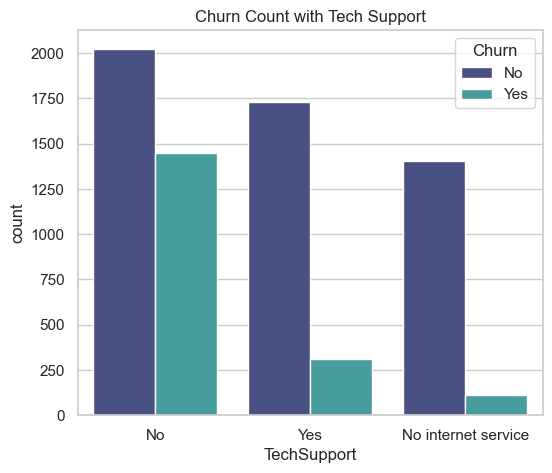


Online Security Churn Rate:
 Churn                  No   Yes
OnlineSecurity                 
No                   0.58  0.42
No internet service  0.93  0.07
Yes                  0.85  0.15

Tech Support Churn Rate:
 Churn                  No   Yes
TechSupport                    
No                   0.58  0.42
No internet service  0.93  0.07
Yes                  0.85  0.15


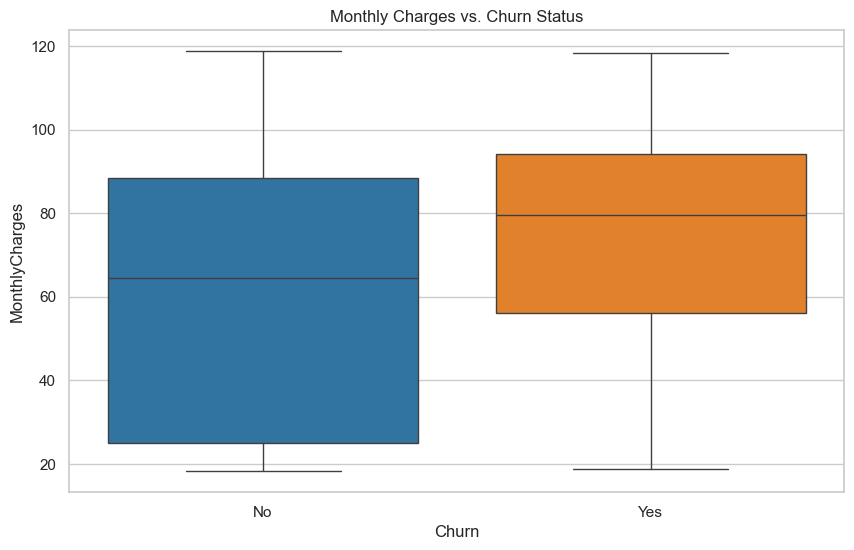

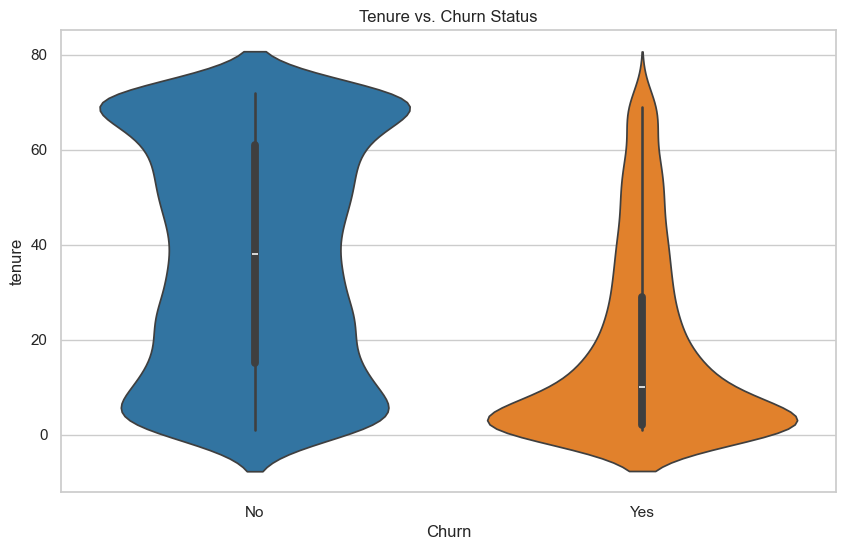

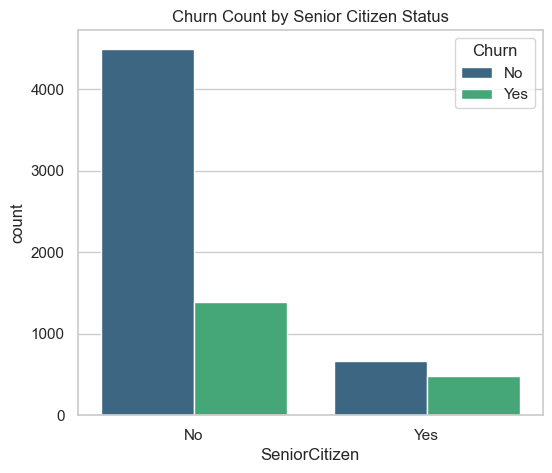

Churn            No   Yes
SeniorCitizen            
0              0.76  0.24
1              0.58  0.42


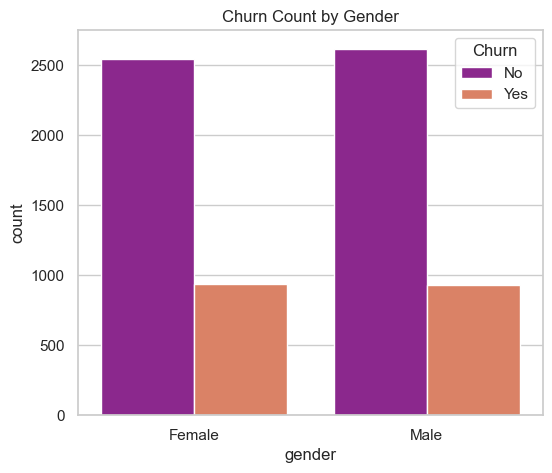

Churn     No   Yes
gender            
Female  0.73  0.27
Male    0.74  0.26


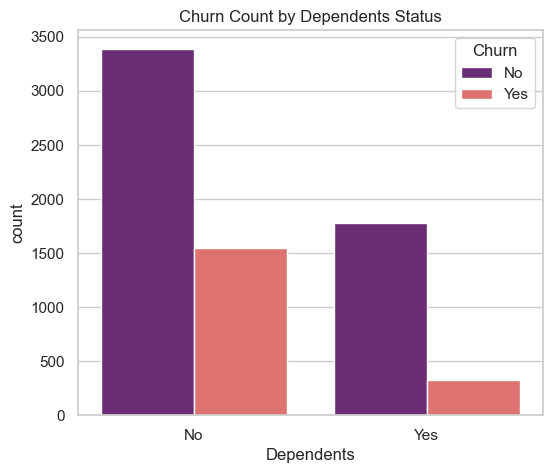

Churn         No   Yes
Dependents            
No          0.69  0.31
Yes         0.84  0.16


In [18]:
# Set a style for the plots
sns.set(style="whitegrid")

# 1: Churn rate by Contract type?
plt.figure(figsize=(8, 6))
sns.countplot(x='Contract', hue='Churn', data=df, palette='viridis')
plt.title('Churn Count by Contract Type')
plt.ylabel('Number of Customers')
plt.xlabel('Contract Type')
plt.show()

# To get the percentages
contract_churn_rate = df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack().round(2)
print(contract_churn_rate)

# 2: How does PaymentMethod affect churn?
plt.figure(figsize=(10, 6))
sns.countplot(x='PaymentMethod', hue='Churn', data=df, palette='plasma')
plt.title('Churn Count by Payment Method')
plt.ylabel('Number of Customers')
plt.xlabel('Payment Method')
plt.xticks(rotation=45, ha='right')
plt.show()

# To get the percentages
payment_churn_rate = df.groupby('PaymentMethod')['Churn'].value_counts(normalize=True).unstack().round(2)
print(payment_churn_rate)

# 3: Do customers with PaperlessBilling churn more?
plt.figure(figsize=(6, 5))
sns.countplot(x='PaperlessBilling', hue='Churn', data=df, palette='magma')
plt.title('Churn Count by PaperlessBilling')
plt.show()

# To get the percentages
billing_churn_rate = df.groupby('PaperlessBilling')['Churn'].value_counts(normalize=True).unstack().round(2)
print(billing_churn_rate)

# 4: How does churn vary across InternetService types?
plt.figure(figsize=(8, 6))
sns.countplot(x='InternetService', hue='Churn', data=df, palette='cividis')
plt.title('Churn Count by Internet Service Type')
plt.show()

# To get the percentages
internet_churn_rate = df.groupby('InternetService')['Churn'].value_counts(normalize=True).unstack().round(2)
print(internet_churn_rate)

# 5: Do customers with OnlineSecurity or TechSupport churn less?
plt.figure(figsize=(6, 5))
sns.countplot(x='OnlineSecurity', hue='Churn', data=df, palette='rocket')
plt.title('Churn Count with Online Security')
plt.show()

plt.figure(figsize=(6, 5))
sns.countplot(x='TechSupport', hue='Churn', data=df, palette='mako')
plt.title('Churn Count with Tech Support')
plt.show()

# To get the percentages for both
security_churn_rate = df.groupby('OnlineSecurity')['Churn'].value_counts(normalize=True).unstack().round(2)
techsupport_churn_rate = df.groupby('TechSupport')['Churn'].value_counts(normalize=True).unstack().round(2)
print("\nOnline Security Churn Rate:\n", security_churn_rate)
print("\nTech Support Churn Rate:\n", techsupport_churn_rate)

# 6: How does MonthlyCharges differ between churned and retained customers?
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df,hue='Churn', palette='tab10')
plt.title('Monthly Charges vs. Churn Status')
plt.show()

# 7: How does tenure differ between churned and retained customers?
plt.figure(figsize=(10, 6))
sns.violinplot(x='Churn', y='tenure', data=df, hue='Churn', palette='tab10')
plt.title('Tenure vs. Churn Status')
plt.show()

# 8: Does senior citizen status affect churn?
plt.figure(figsize=(6, 5))
sns.countplot(x='SeniorCitizen', hue='Churn', data=df, palette='viridis')
plt.title('Churn Count by Senior Citizen Status')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# To get the percentages
senior_churn_rate = df.groupby('SeniorCitizen')['Churn'].value_counts(normalize=True).unstack().round(2)
print(senior_churn_rate)

# 9: Does gender affect churn?
plt.figure(figsize=(6, 5))
sns.countplot(x='gender', hue='Churn', data=df, palette='plasma')
plt.title('Churn Count by Gender')
plt.show()

# To get the percentages
gender_churn_rate = df.groupby('gender')['Churn'].value_counts(normalize=True).unstack().round(2)
print(gender_churn_rate)

# 10: Do customers with dependents churn less?
plt.figure(figsize=(6, 5))
sns.countplot(x='Dependents', hue='Churn', data=df, palette='magma')
plt.title('Churn Count by Dependents Status')
plt.show()

# To get the percentages
dependents_churn_rate = df.groupby('Dependents')['Churn'].value_counts(normalize=True).unstack().round(2)
print(dependents_churn_rate)

## 6) Multivariate Analysis:

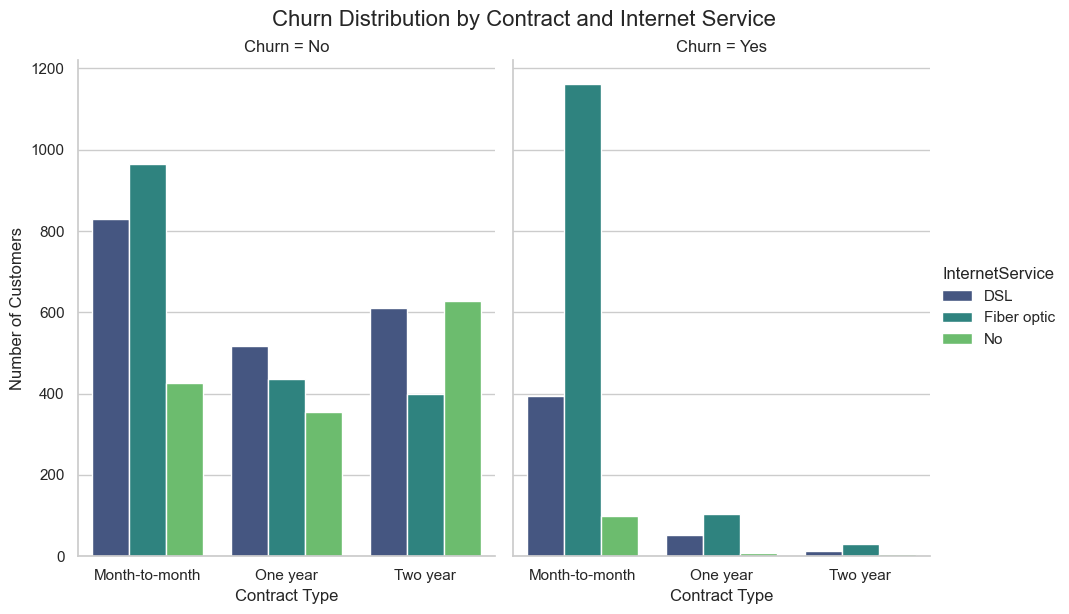

Churn Rate by Contract and Internet Service (%):
 Churn                              No    Yes
Contract       InternetService              
Month-to-month DSL              67.78  32.22
               Fiber optic      45.39  54.61
               No               81.11  18.89
One year       DSL              90.70   9.30
               Fiber optic      80.71  19.29
               No               97.52   2.48
Two year       DSL              98.07   1.93
               Fiber optic      92.77   7.23
               No               99.21   0.79


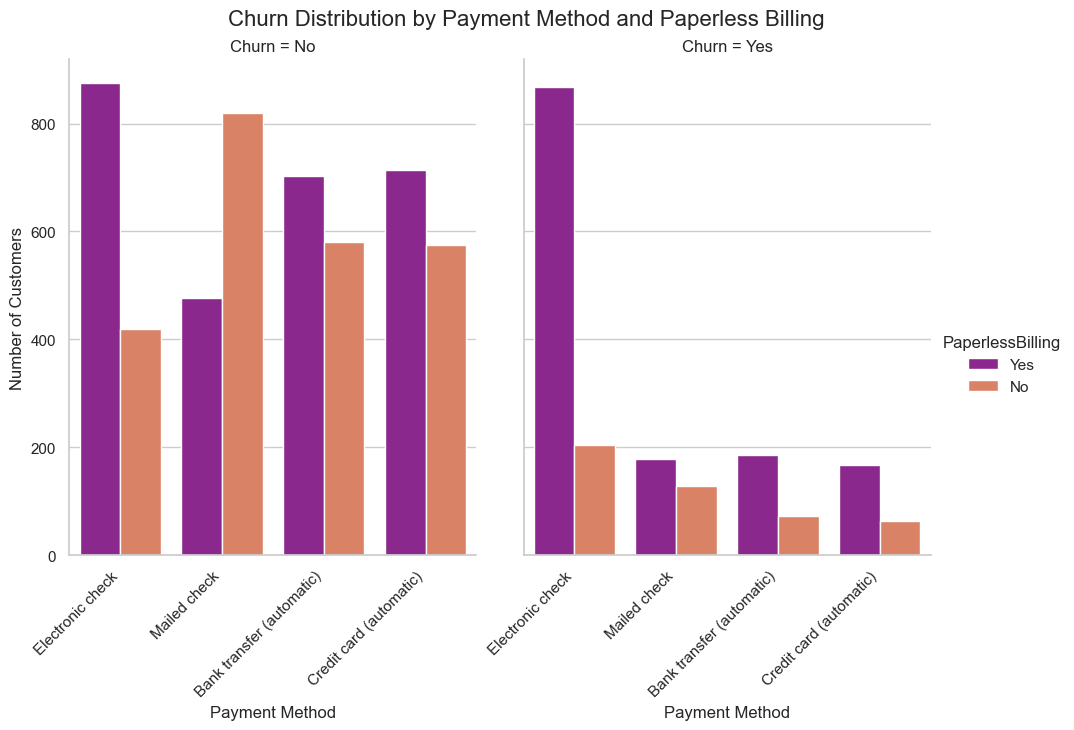

Churn Rate by Payment Method and Paperless Billing (in %):
 Churn                                          No    Yes
PaymentMethod             PaperlessBilling              
Bank transfer (automatic) No                88.97  11.03
                          Yes               79.08  20.92
Credit card (automatic)   No                89.98  10.02
                          Yes               80.95  19.05
Electronic check          No                67.26  32.74
                          Yes               50.23  49.77
Mailed check              No                86.41  13.59
                          Yes               72.67  27.33


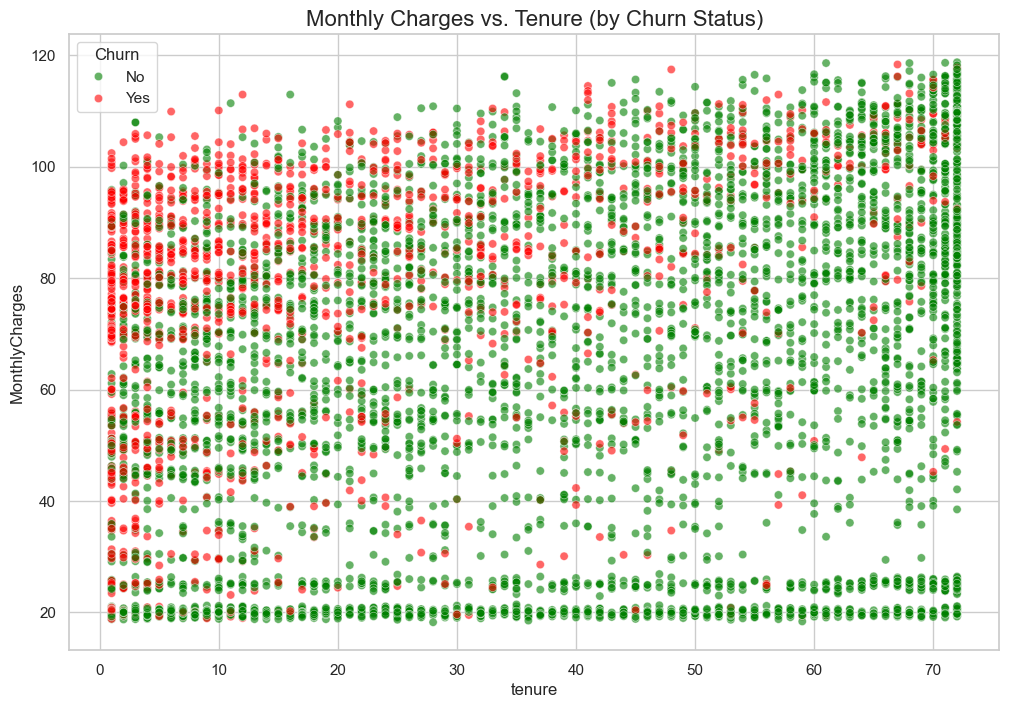

Churn Rate by Number of Add-on Services:
 NumAddons
0    21.46
1    45.76
2    35.82
3    27.39
4    22.35
5    12.48
6     5.28
Name: Churn_binary, dtype: float64


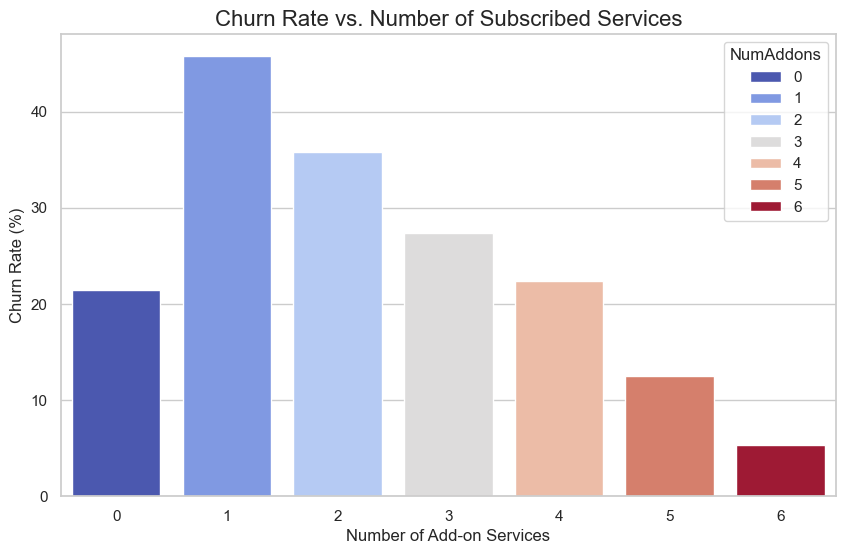

In [19]:
sns.set(style="whitegrid")

# 1: How does churn vary across Contract type and InternetService?
g = sns.catplot(
    data=df,
    x="Contract",
    hue="InternetService",
    col="Churn",
    kind="count",
    height=6,
    aspect=0.8,
    palette="viridis"
)
g.fig.suptitle('Churn Distribution by Contract and Internet Service', y=1.02, fontsize=16)
g.set_axis_labels("Contract Type", "Number of Customers")
plt.show()

contract_internet_churn = df.groupby(['Contract', 'InternetService'])['Churn'].value_counts(normalize=True).unstack() * 100
print("Churn Rate by Contract and Internet Service (%):\n", contract_internet_churn.round(2))


# 2: How does churn vary by PaymentMethod and PaperlessBilling together?
g = sns.catplot(
    data=df,
    x="PaymentMethod",
    hue="PaperlessBilling",
    col="Churn",
    kind="count",
    height=6,
    aspect=0.8,
    palette="plasma"
)
g.fig.suptitle('Churn Distribution by Payment Method and Paperless Billing', y=1.02, fontsize=16)
g.set_axis_labels("Payment Method", "Number of Customers")
g.set_xticklabels(rotation=45, ha='right')
plt.show()

payment_billing_churn = df.groupby(['PaymentMethod', 'PaperlessBilling'])['Churn'].value_counts(normalize=True).unstack() * 100
print("Churn Rate by Payment Method and Paperless Billing (in %):\n", payment_billing_churn.round(2))


# 3: Are short-tenure, high-monthly-charge customers more likely to churn?
# Convert Churn column to a binary integer for plotting
df['Churn_binary'] = df['Churn'].map({'Yes': 1, 'No': 0})
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='tenure',
    y='MonthlyCharges',
    hue='Churn',
    alpha=0.6,
    palette={'Yes': 'red', 'No': 'green'}
)
plt.title('Monthly Charges vs. Tenure (by Churn Status)', fontsize=16)
plt.show()


# 4 & 5: How does churn change with the number of subscribed services? Do bundled services reduce churn?
# Create a new feature to count the number of subscribed add-on services
add_on_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['NumAddons'] = df[add_on_cols].apply(lambda x: (x == 'Yes').sum(), axis=1)

# Group by the new feature and calculate the churn rate
churn_by_addons = df.groupby('NumAddons')['Churn_binary'].mean() * 100
print("Churn Rate by Number of Add-on Services:\n", churn_by_addons.round(2))

plt.figure(figsize=(10, 6))
sns.barplot(x=churn_by_addons.index, y=churn_by_addons.values, hue=churn_by_addons.index, palette='coolwarm')
plt.title('Churn Rate vs. Number of Subscribed Services', fontsize=16)
plt.xlabel('Number of Add-on Services')
plt.ylabel('Churn Rate (%)')
plt.show()

# Clean up the temporary columns
df.drop(['Churn_binary', 'NumAddons'], axis=1, inplace=True)

## 7) Business Insight Questions:

### 1. Which three features are most strongly related to churn?

Based on our analysis, the three features most strongly related to customer churn are:

1.  **Contract Type**: Customers on a **Month-to-month** contract have a significantly higher churn rate compared to those on one-year or two-year contracts. This indicates a low-commitment customer base is a high-risk segment.
2.  **Internet Service**: Customers with **Fiber optic** internet service have a notably higher churn rate than those with DSL or no internet service. This suggests potential issues with the quality, reliability, or cost of the fiber service.
3.  **Tenure**: The distribution of `tenure` showed a clear trend: customers who churned had a much shorter tenure, particularly within the first few months. This points to a high churn risk during the early stages of a customer's life cycle.


### 2. Which customer segment has the highest churn risk?

The customer segment with the highest churn risk is **new customers on a month-to-month contract with Fiber optic internet service.**

* They are new, so they have a **short tenure**.
* They are not locked into a long-term agreement, so they have a **Month-to-month contract**.
* They often have the highest `MonthlyCharges` because they are on the Fiber optic plan, a service that we've found to have a high churn rate.


### 3. Which segment is high-value but high-risk?

The high-value, high-risk segment is **customers on a Fiber optic plan with high monthly charges who have been with the company for a short period.**

* **High-value**: These customers generate the most revenue per month due to their premium internet service.
* **High-risk**: Our analysis showed that this group is highly prone to churning early. Their high churn rate suggests that they may be dissatisfied with the service quality despite its high cost.


### 4. What patterns indicate early-stage churn risk?

The most prominent patterns indicating early-stage churn risk are:

* **Short Tenure**: The majority of churn occurs within the first few months of a customer's subscription. This suggests a potential issue with the initial onboarding process, first-use experience, or a disconnect between customer expectations and actual service delivery.
* **Month-to-month Contract**: This contract type is strongly associated with early churn. Without a long-term commitment, customers feel less tied to the service and can switch providers with minimal friction.
* **High Monthly Charges and Electronic Check Payment**: Customers who pay via electronic check and have high monthly charges are more likely to churn, indicating they may be reacting to unexpected costs or dissatisfaction with an expensive service.


### 5. Which features should be targeted in retention strategies?

To effectively reduce churn, retention strategies should primarily target the following features:

1.  **Contract**: Offer incentives for customers on month-to-month contracts to switch to one- or two-year plans. This could include discounted rates, free service add-ons, or a price-lock guarantee to increase customer commitment and reduce churn.
2.  **Internet Service**: Focus on improving the quality and reliability of the Fiber optic service. Address customer complaints, invest in network infrastructure, and provide proactive support to reduce dissatisfaction among this high-value, high-risk segment.
3.  **Customer Tenure**: Implement a targeted welcome and engagement program for new customers, especially within the first six months. This could involve check-in calls, personalized support, or educational content to ensure a smooth onboarding process and build customer loyalty.
4.  **Payment Method**: The high churn rate for customers using **Electronic Check** suggests potential issues with that payment process or a correlation with a less loyal customer segment. The company should investigate if there are friction points in the billing process or consider offering incentives for customers to switch to a more secure and automated payment method like a credit card or bank transfer.

***

#  **VISUALIZATIONS**

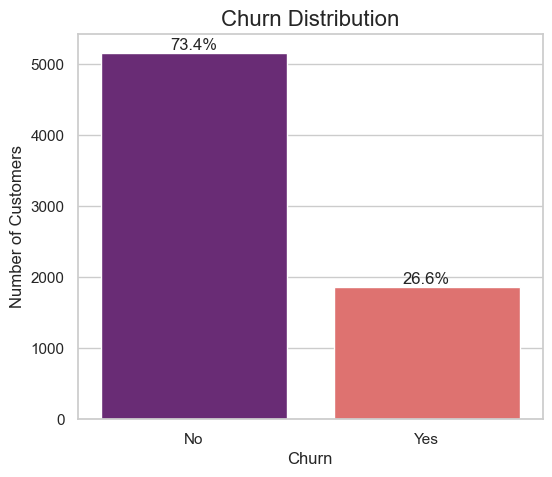

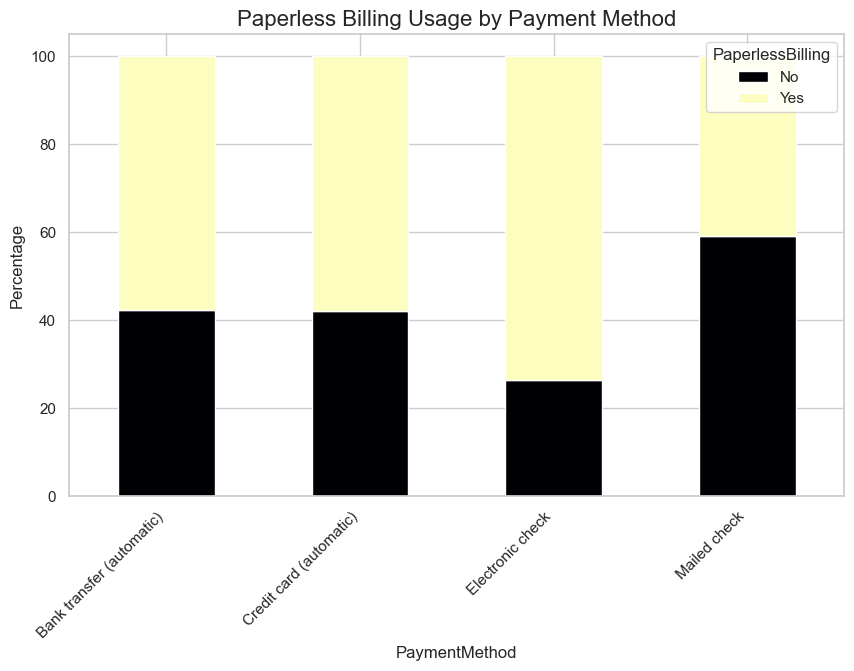

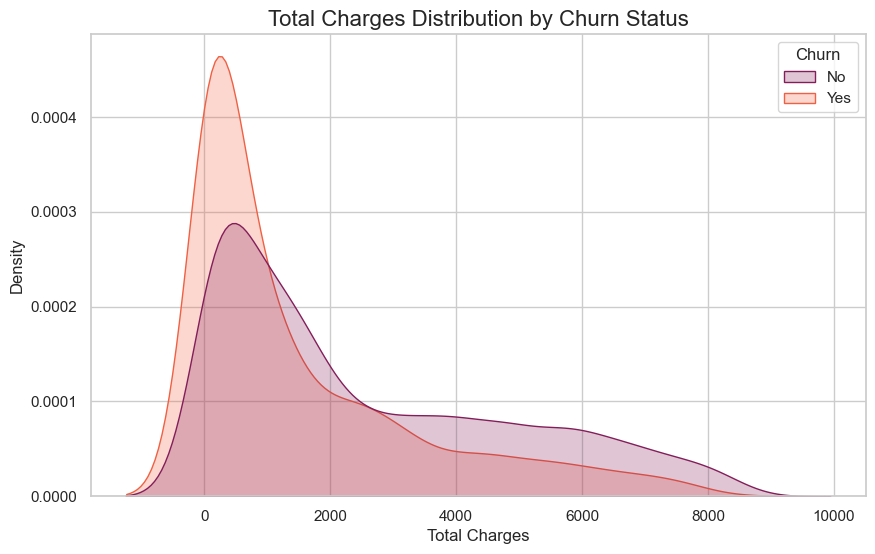

In [20]:
sns.set(style="whitegrid")

# 1. Churn Distribution 
plt.figure(figsize=(6, 5))
ax = sns.countplot(x='Churn', data=df, hue='Churn', palette='magma')
plt.title('Churn Distribution', fontsize=16)
plt.ylabel('Number of Customers')
plt.xlabel('Churn')

total = len(df['Churn'])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')
plt.show()

# 2. Contract Type & Churn - EDA Q5
# 3. Payment Method & Churn – EDA Q5
# 4. Internet Service & Churn – EDA Q5
# 5. Tenure Distribution – EDA Q4
# 6. Monthly Charges vs Churn – EDA Q5
# 7. Tenure vs Monthly Charges – EDA Q6
# 8. Bundle Depth vs Churn – EDA Q6

# 9. Payment Friction – 100% stacked bar for PaymentMethod × PaperlessBilling.
payment_billing = pd.crosstab(df['PaymentMethod'], df['PaperlessBilling'], normalize='index') * 100
payment_billing.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='magma')
plt.title('Paperless Billing Usage by Payment Method', fontsize=16)
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.show()

# 10. Customer Value at Risk – KDE or histogram of TotalCharges for churned vs retained.
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='TotalCharges', hue='Churn', fill=True, common_norm=False, palette='rocket')
plt.title('Total Charges Distribution by Churn Status', fontsize=16)
plt.xlabel('Total Charges')
plt.ylabel('Density')
plt.show()

***

# **ML Model Training**

In [21]:
# Content of Telco-Customer-Churn.csv 
csv_content = """customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes
9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.1,1949.4,No
6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.8,3046.05,Yes
6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No
9763-GRSKD,Male,0,Yes,Yes,13,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,49.95,587.45,No
7469-LKBCI,Male,0,No,No,16,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),18.95,326.8,No
8091-TTVAX,Male,0,Yes,No,58,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,One year,No,Credit card (automatic),100.35,5681.1,No
0280-XJGEX,Male,0,No,No,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.7,5036.3,Yes
5129-JLPIS,Male,0,No,No,25,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,105.5,2686.05,No
3655-SNQYZ,Female,0,Yes,Yes,69,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),113.25,7895.15,No
8191-XWSZG,Female,0,No,No,52,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.65,1022.95,No
9959-WOFKT,Male,0,No,Yes,71,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Two year,No,Bank transfer (automatic),106.7,7382.25,No
4190-MFLUW,Female,0,Yes,Yes,10,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Credit card (automatic),55.2,528.35,Yes
4183-MYFRB,Female,0,No,No,21,Yes,No,Fiber optic,No,Yes,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,90.05,1862.9,No
8779-QRDMV,Male,1,No,No,1,No,No phone service,DSL,No,No,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,39.65,39.65,Yes
1680-VDCWW,Male,0,Yes,No,12,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),19.8,202.25,No
1066-JKSGK,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.15,20.15,Yes
3638-WEABW,Female,0,Yes,No,58,Yes,Yes,DSL,No,Yes,No,Yes,No,No,Two year,Yes,Credit card (automatic),59.9,3505.1,No
6322-HRPFA,Male,0,Yes,Yes,49,Yes,No,DSL,Yes,Yes,No,Yes,No,No,Month-to-month,No,Credit card (automatic),59.6,2970.3,No
6865-JZNKO,Female,0,No,No,30,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),55.3,1530.6,No
6467-CHFZW,Male,0,Yes,Yes,47,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.35,4749.15,Yes
8665-UTDHZ,Male,0,Yes,Yes,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No,Electronic check,30.2,30.2,Yes
5248-YGIJN,Male,0,Yes,No,72,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),90.25,6369.45,No
8773-HHUOZ,Female,0,No,Yes,17,Yes,No,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Mailed check,64.7,1093.1,Yes
3841-NFECX,Female,1,Yes,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,No,Two year,Yes,Credit card (automatic),96.35,6766.95,No
4929-XIHVW,Male,1,Yes,No,2,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),95.5,181.65,No
6827-IEAUQ,Female,0,Yes,Yes,27,Yes,No,DSL,Yes,Yes,Yes,Yes,No,No,One year,No,Mailed check,66.15,1874.45,No
7310-EGVHZ,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),20.2,20.2,No
3413-BMNZE,Male,1,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),45.25,45.25,No
6234-RAAPL,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,No,Two year,No,Bank transfer (automatic),99.9,7251.7,No
6047-YHPVI,Male,0,No,No,5,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,69.7,316.9,Yes
6572-ADKRS,Female,0,No,No,46,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),74.8,3548.3,No
5380-WJKOV,Male,0,No,No,34,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,106.35,3549.25,Yes
8168-UQWWF,Female,0,No,No,11,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),97.85,1105.4,Yes
8865-TNMNX,Male,0,Yes,Yes,10,Yes,No,DSL,No,Yes,No,No,No,No,One year,No,Mailed check,49.55,475.7,No
9489-DEDVP,Female,0,Yes,Yes,70,Yes,Yes,DSL,Yes,Yes,No,No,Yes,No,Two year,Yes,Credit card (automatic),69.2,4872.35,No
9867-JCZSP,Female,0,Yes,Yes,17,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.75,418.25,No
4671-VJLCL,Female,0,No,No,63,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,Yes,Credit card (automatic),79.85,4861.45,No
4080-IIARD,Female,0,Yes,No,13,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Month-to-month,Yes,Electronic check,76.2,981.45,No
3714-NTNFO,Female,0,No,No,49,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,84.5,3906.7,No
5948-UJZLF,Male,0,No,No,2,Yes,No,DSL,No,Yes,No,No,No,No,Month-to-month,No,Mailed check,49.25,97,No
7760-OYPDY,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,80.65,144.15,Yes
7639-LIAYI,Male,0,No,No,52,Yes,Yes,DSL,Yes,No,No,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),79.75,4217.8,No
2954-PIBKO,Female,0,Yes,Yes,69,Yes,Yes,DSL,Yes,No,Yes,Yes,No,No,Two year,Yes,Credit card (automatic),64.15,4254.1,No
8012-SOUDQ,Female,1,No,No,43,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Electronic check,90.25,3838.75,No
9420-LOJKX,Female,0,No,No,15,Yes,No,Fiber optic,Yes,Yes,No,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),99.1,1426.4,Yes
6575-SUVOI,Female,1,Yes,No,25,Yes,Yes,DSL,Yes,No,No,Yes,Yes,No,Month-to-month,Yes,Credit card (automatic),69.5,1752.65,No
7495-OOKFY,Female,1,Yes,No,8,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Credit card (automatic),80.65,633.3,Yes
4667-QONEA,Female,1,Yes,Yes,60,Yes,No,DSL,Yes,Yes,Yes,Yes,No,Yes,One year,Yes,Credit card (automatic),74.85,4456.35,No
1658-BYGOY,Male,1,No,No,18,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.45,1752.55,Yes
8769-KKTPH,Female,0,Yes,Yes,63,Yes,Yes,Fiber optic,Yes,No,No,No,Yes,Yes,One year,Yes,Credit card (automatic),99.65,6311.2,No
5067-XJQFU,Male,1,Yes,Yes,66,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,108.45,7076.35,No
3957-SQXML,Female,0,Yes,Yes,34,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.95,894.3,No
5954-BDFSG,Female,0,No,No,72,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),107.5,7853.7,No
0434-CSFON,Female,0,Yes,No,47,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,100.5,4707.1,No
1215-FIGMP,Male,0,No,No,60,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),89.9,5450.7,No
0526-SXDJP,Male,0,Yes,No,72,No,No phone service,DSL,Yes,Yes,Yes,No,No,No,Two year,No,Bank transfer (automatic),42.1,2962,No
0557-ASKVU,Female,0,Yes,Yes,18,Yes,No,DSL,No,No,Yes,Yes,No,No,One year,Yes,Credit card (automatic),54.4,957.1,No
"""

In [22]:
print("ML Model Training")
df = pd.read_csv(io.StringIO(csv_content))

# Data Cleaning & Preprocessing
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df.dropna(inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

# Drop customerID
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)
print("Data pre-processing is complete.")


# 1: Target & Features 
# Encode Churn as a binary variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
X = df.drop('Churn', axis=1)
y = df['Churn']
print("Target variable 'Churn' has been encoded.")


# 2: Encoding and Scaling 
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Create a preprocessing pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

print("Preprocessing pipeline created for encoding and scaling.")


# 3: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\n\nData split into training (80%) and testing (20%) sets.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


# 4: Baseline Models 
# Create pipelines for each model
lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))])

rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))])

print("\n\nTraining Logistic Regression model...")
lr_model.fit(X_train, y_train)

print("Training Random Forest model...")
rf_model.fit(X_train, y_train)
print("Models trained successfully.")


# 5: Evaluation Metrics
print("\n\nModel Evaluation")
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Logistic Regression Metrics
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_lr):.4f}")
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr)
print(f"PR-AUC Score: {auc(recall_lr, precision_lr):.4f}")

# Random Forest Metrics
print("\n\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_rf):.4f}")
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
print(f"PR-AUC Score: {auc(recall_rf, precision_rf):.4f}")


ML Model Training
Data pre-processing is complete.
Target variable 'Churn' has been encoded.
Preprocessing pipeline created for encoding and scaling.


Data split into training (80%) and testing (20%) sets.
Training set shape: (51, 19)
Testing set shape: (13, 19)


Training Logistic Regression model...
Training Random Forest model...
Models trained successfully.


Model Evaluation
Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.50      0.75      0.60         4

    accuracy                           0.69        13
   macro avg       0.68      0.71      0.68        13
weighted avg       0.75      0.69      0.70        13

ROC-AUC Score: 0.7500
PR-AUC Score: 0.4202


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71         9
           1       0.40      0.50      0.44         4

    accuracy        

In [23]:
# 6: Feature Importance 
print("\nFeature Importance")

# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Logistic Regression Feature Importance (Coefficients)
print("\nLogistic Regression Feature Importance (Top 10):")
lr_coefficients = lr_model.named_steps['classifier'].coef_[0]
lr_feature_importance = pd.Series(lr_coefficients, index=feature_names)
print(lr_feature_importance.abs().sort_values(ascending=False).head(10))

# Random Forest Feature Importance
print("\nRandom Forest Feature Importance (Top 10):")
rf_importances = rf_model.named_steps['classifier'].feature_importances_
rf_feature_importance = pd.Series(rf_importances, index=feature_names)
print(rf_feature_importance.sort_values(ascending=False).head(10))


Feature Importance

Logistic Regression Feature Importance (Top 10):
num__tenure                     1.237941
cat__StreamingMovies_No         0.734838
cat__Contract_Month-to-month    0.710200
num__TotalCharges               0.667361
cat__OnlineSecurity_Yes         0.591086
cat__Contract_One year          0.560048
cat__StreamingMovies_Yes        0.503994
cat__PaperlessBilling_No        0.468676
num__MonthlyCharges             0.441088
cat__DeviceProtection_No        0.383554
dtype: float64

Random Forest Feature Importance (Top 10):
num__tenure                     0.158143
num__TotalCharges               0.123461
cat__Contract_Month-to-month    0.066477
num__MonthlyCharges             0.063270
cat__TechSupport_Yes            0.034111
cat__Contract_Two year          0.032668
cat__TechSupport_No             0.032475
cat__StreamingMovies_Yes        0.032122
cat__StreamingMovies_No         0.032011
cat__OnlineSecurity_Yes         0.031278
dtype: float64


## Business Recommendations

1. **Contract type** is the single most important predictor of churn for both models. Target customers on month-to-month contracts with proactive retention offers.

2. **Tenure** is a key factor. The short tenure of churned customers suggests an issue with early-stage customer experience. Focus on improving onboarding and initial service quality.

3. **Internet Service** and **Monthly Charges** are highly important. The high churn for fiber optic customers with high monthly charges points to dissatisfaction with this premium service. Investigate and resolve service quality issues for this segment.

4. **Service Add-ons** like *Online Security* and *Tech Support* are significant. The models show that the absence of these services increases churn risk. Offer these add-ons as part of a targeted, high-value bundle to at-risk customers.

5. **Payment Method** is a strong predictor. The high churn associated with electronic checks could be a sign of customers who are more active in managing their account and are more likely to switch providers. Offer incentives to switch to automated payment methods.